# Krypton Corrections

## Correct energy using Kr XY maps and obtain resolution

### Authors: GML, JAH, JJGC

### Software: KrCalib, IC

In [1]:
%load_ext autoreload
%autoreload 2
import os
import time
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Thu Aug 30 22:36:51 2018


### Input files

In [2]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_9999.h5','dst_6206_10000_19999.h5',
                    'dst_6206_20000_29999.h5','dst_6206_30000_39299.h5']
output_file_name  = 'ldst_6206.h5'
map_file_name     = 'kr_maps_xy_6206.h5'
map_file_name_ts  = 'kr_maps_xy_ts_6206.h5'
emap_file_name    = ' '

krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [5]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [6]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_energy_map
from krcal.core.io_functions       import read_energy_map
from krcal.core.io_functions       import read_maps_ts

In [8]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg
from krcal.core.core_functions      import NN

In [9]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import events_sector
from krcal.core.analysis_functions      import event_map
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event

In [10]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [11]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [12]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [13]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [32]:
from krcal.core.map_functions   import energy_map
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import rphi_sector_alpha_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps
from krcal.core.map_functions   import draw_map
from krcal.core.map_functions   import draw_maps_ts
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import draw_xy_maps
from krcal.core.map_functions   import draw_xy_map
from krcal.core.map_functions   import draw_xy_maps_ts
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean

In [15]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [16]:
from krcal.core.correction_functions import e0_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_correction
from krcal.core.correction_functions import lt_correction_ts
from krcal.core.correction_functions import e0_correction_ts

In [17]:
import krcal.dev.corrections       as corrections 


In [18]:
from numpy import pi

In [19]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [20]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [21]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_10000_19999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_20000_29999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_30000_39299.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206.h5', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_xy_6206.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_xy_ts_6206.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/ ')

In [22]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [23]:
#unique_events = ~dst.event.duplicated()
#number_of_evts_full = np.count_nonzero(unique_events)

# Above does not work when glueing multiple DSTs, events ARE duplicated,
# since event number starts at 0, rather than taking true event number. 

print(f"Total number of events: {len(dst)}")

Total number of events: 4085430


In [24]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [26]:
RMAX      = 200.
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-RMAX,  RMAX)
z_range   = (50,  550)

s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)


krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

### Fiducial cut at RMAX

In [27]:
dst = dst[in_range(dst.R, 0, RMAX)]

### Time differences in seconds

In [62]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Raw S2 energy vs Z

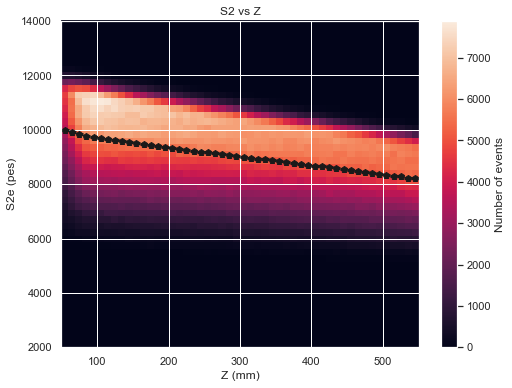

In [28]:
nevt = h2d(dst.Z, dst.S2e, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(8,6))

### Load average maps

In [45]:
amap = read_maps(fn.map_file_name)

In [46]:
norm = amap_max(amap)

In [47]:
norm

ASectorMap(chi2=53.966505974199514, e0=12375.648831701425, lt=3001.718671487905, e0u=3.5505678584494995, ltu=63.09465188067827)

In [48]:
print(f'normalizing to {norm.e0}')

normalizing to 12375.648831701425


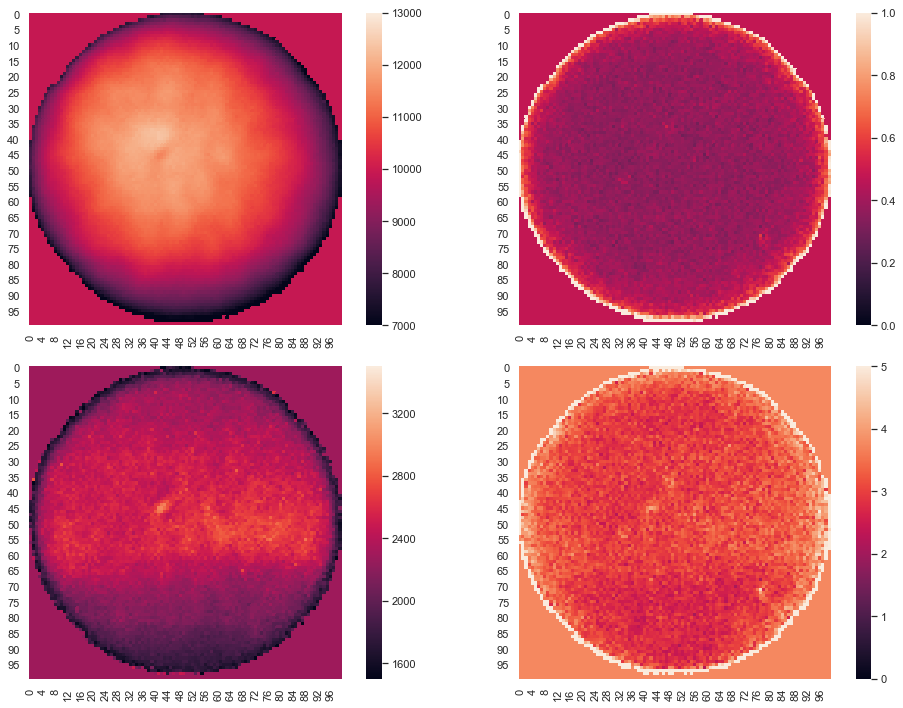

In [49]:
draw_xy_maps(amap,
            e0lims  = (7000, 13000),
            ltlims  = (1500, 3500),
            eulims  = (0, 1),
            lulims  = (0, 5),
            figsize=(14,10))

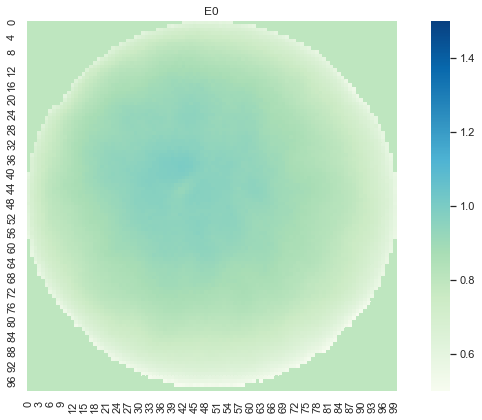

In [50]:
draw_xy_map(amap,
            wmap    = MapType.E0,
            norm    = norm.e0,
            alims   = (0.5, 1.5),
            cmap    = matplotlib.cm.GnBu, 
            figsize =(10,6))

### Load TS Maps

In [51]:
ts, tsMaps = read_maps_ts(fn.map_file_name_ts)

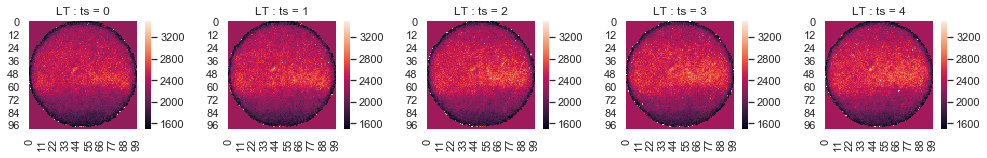

In [52]:
draw_xy_maps_ts(tsMaps,   
                wmap    = MapType.LT,
                ltlims  = (1500, 3500),
                figsize = (14,10))

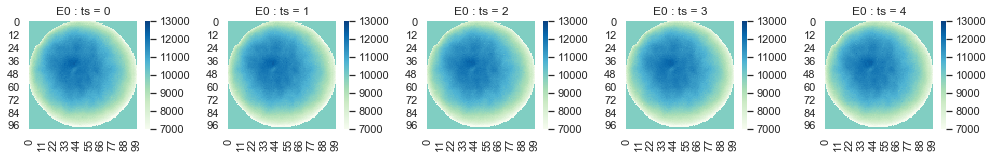

In [53]:
draw_xy_maps_ts(tsMaps,   
                wmap    = MapType.E0,
                ltlims  = (7000, 13000),
                cmap    = matplotlib.cm.GnBu, 
                figsize = (14,10))

### E0 (geometry) correction

In [54]:
t0 = time.time()
E0 = e0_xy_correction(dst.S2e.values,
                      dst.X.values,
                      dst.Y.values,
                      E0M = amap.e0 / norm.e0, 
                      xr  = krRanges.X,
                      yr  = krRanges.Y,
                      nx  = krNbins.X, 
                      ny  = krNbins.Y)


t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 34.16683912277222


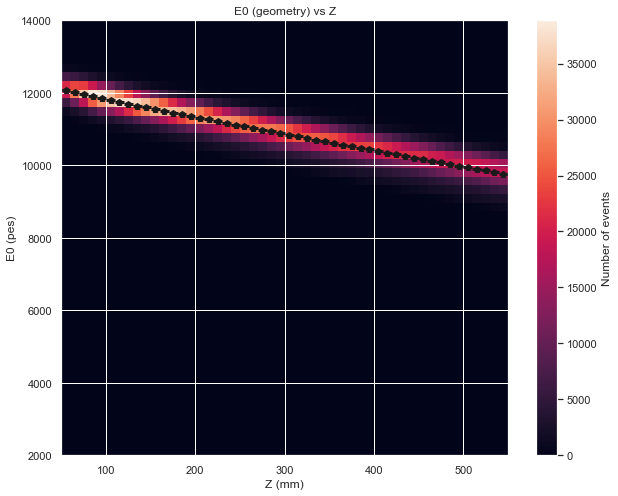

In [55]:
nevt = h2d(dst.Z, E0, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='E0 (pes)', title='E0 (geometry) vs Z'),
           profile=True,
           figsize=(10,8))

In [56]:
t0 = time.time()
E = lt_xy_correction(E0, 
                     dst.X.values, 
                     dst.Y.values,
                     dst.Z.values, 
                     LTM = amap.lt,
                     xr  = krRanges.X,
                     yr  = krRanges.Y,
                     nx  = krNbins.X, 
                     ny  = krNbins.Y)
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 33.91104698181152


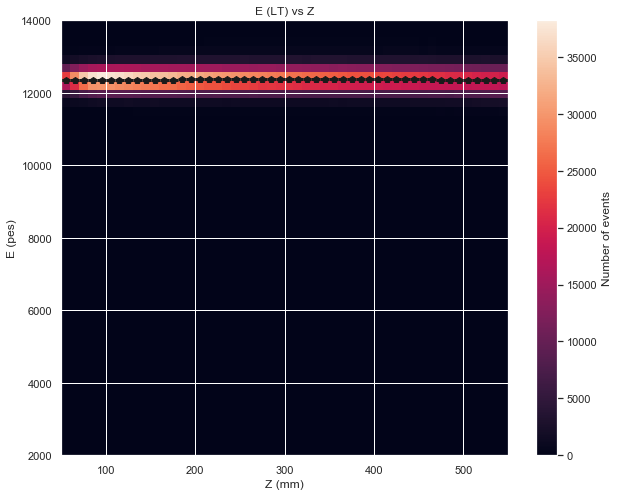

In [57]:
nevt = h2d(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='E (pes)', title='E (LT) vs Z'),
           profile=True,
           figsize=(10,8))

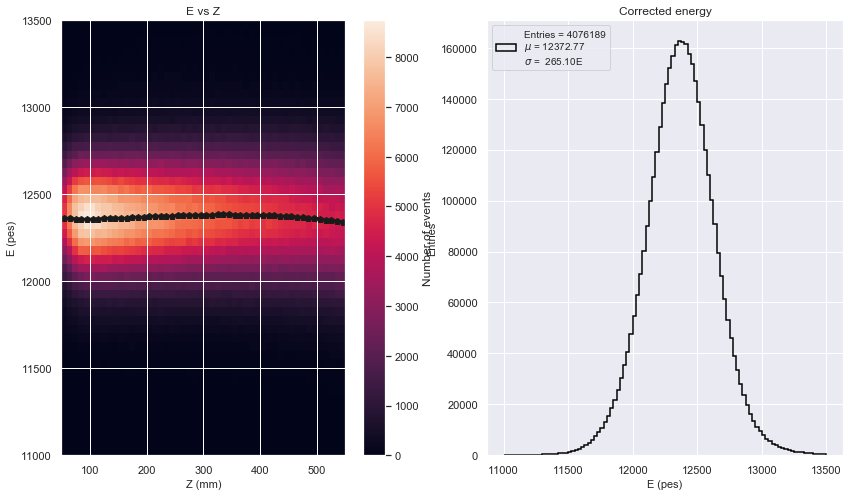

In [59]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, (11000, 13500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =(11000,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Corrected energy'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12371.934914894904 +-0.1288450952081669 
 E sigma   = 255.7498584308845 +-0.09989040759995237 
 chi2    = 11.137024563139525 
 sigma E/E (FWHM)     (%) =4.857867192535938
 sigma E/E (FWHM) Qbb (%) =0.6274030515757191 


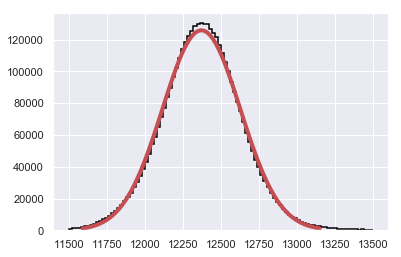

In [60]:
fc = fit_energy(E, nbins=100, range=(11500, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

### Using time dependent maps

In [63]:
kdst = kr_event(dst, DT, dst.S2e, dst.S2q)

In [64]:
t0 = time.time()
kge =  e0_xy_correction_ts(kdst, ts, tsMaps, 
                           xr  = krRanges.X,
                           yr  = krRanges.Y,
                           nx  = krNbins.X, 
                           ny  = krNbins.Y)                
t1 = time.time()
print(f' E0 correction: t = {t1 -t0}')

time sector 0
time sector 1
time sector 2
time sector 3
time sector 4
 E0 correction: t = 34.64949297904968


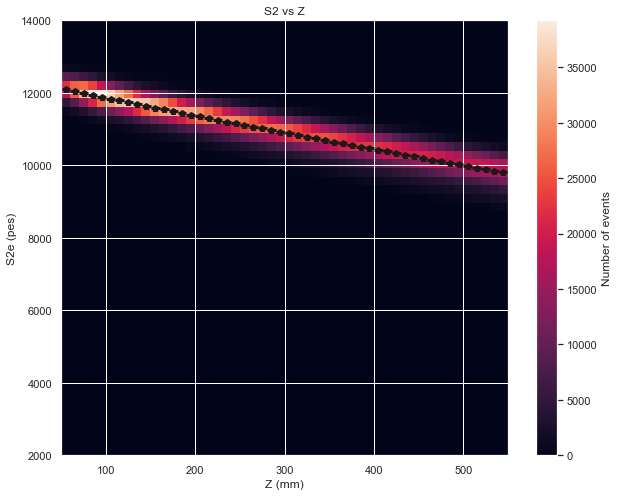

In [65]:
nevt = h2d(kge.Z, kge.E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [66]:
t0 = time.time()
kre = lt_xy_correction_ts(kge, ts, tsMaps, 
                          xr  = krRanges.X,
                          yr  = krRanges.Y,
                          nx  = krNbins.X, 
                          ny  = krNbins.Y)
                  
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

time sector 0
time sector 1
time sector 2
time sector 3
time sector 4
 LT correction: t = 34.48123598098755


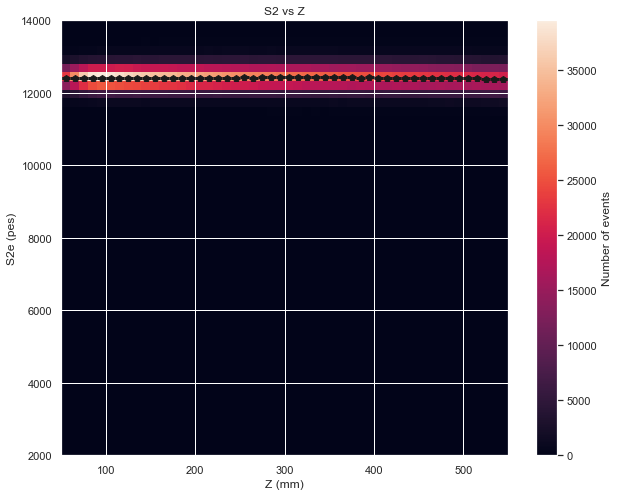

In [67]:
nevt = h2d(kre.Z, kre.E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

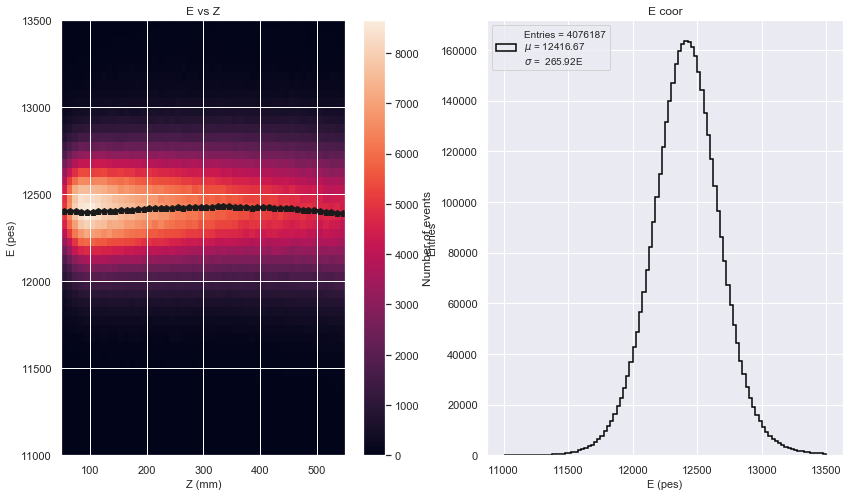

In [69]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(kre.Z, kre.E, krNbins.Z, krNbins.S2e, krRanges.Z, (11000, 13500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kre.E,  bins = 100, range =(11000,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12371.934914894904 +-0.1288450952081669 
 E sigma   = 255.7498584308845 +-0.09989040759995237 
 chi2    = 11.137024563139525 
 sigma E/E (FWHM)     (%) =4.857867192535938
 sigma E/E (FWHM) Qbb (%) =0.6274030515757191 


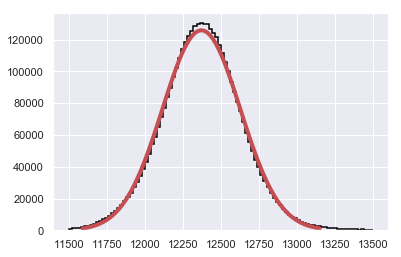

In [70]:
fc = fit_energy(E, nbins=100, range=(11500, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

### Using time-dependent does not buy any extra resolution. Why??

### Time dependence before/after correction

#### Before

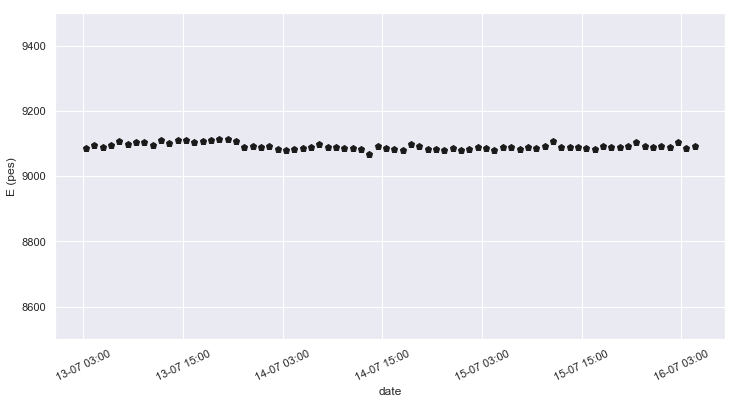

In [72]:
energy_time_profile(kge.T, kge.S2e, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(8500, 9500),  
                    figsize=(12,6))

#### After

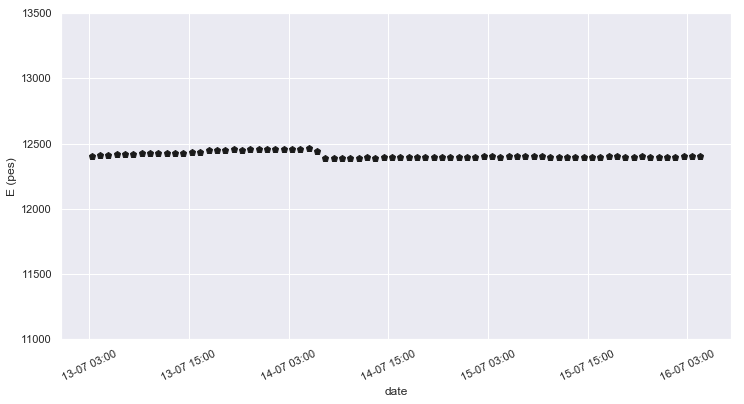

In [73]:
energy_time_profile(kre.T, kre.E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(11000, 13500),  
                    figsize=(12,6))

### Radial dependence

#### Before

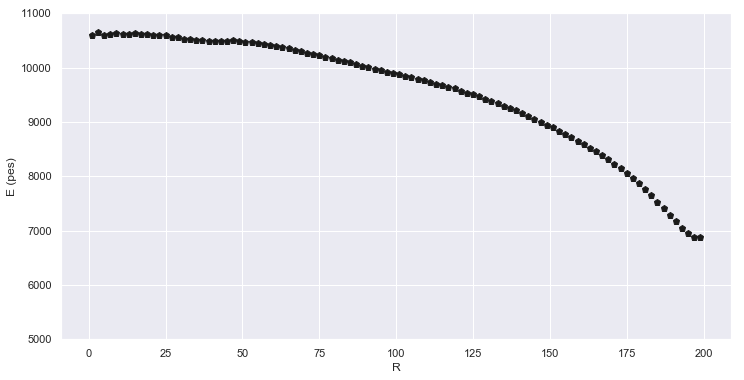

In [75]:
energy_X_profile(dst.R, dst.S2e, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(5000, 11000),  
                 figsize=(12,6))

#### After: Further corrections needed!

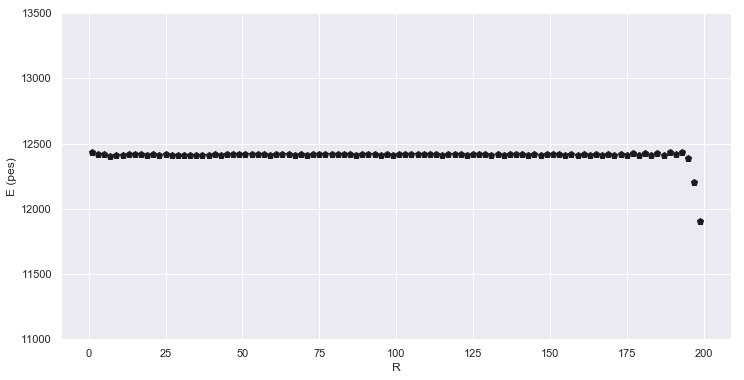

In [76]:
energy_X_profile(kre.R, kre.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(11000, 13500),  
                 figsize=(12,6))

### Phi distribution

#### Before

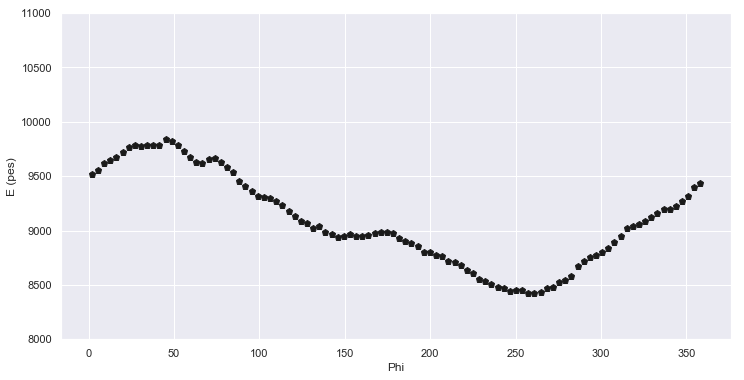

In [77]:
energy_X_profile(phirad_to_deg(dst.Phi), dst.S2e, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After! Further correction needed.

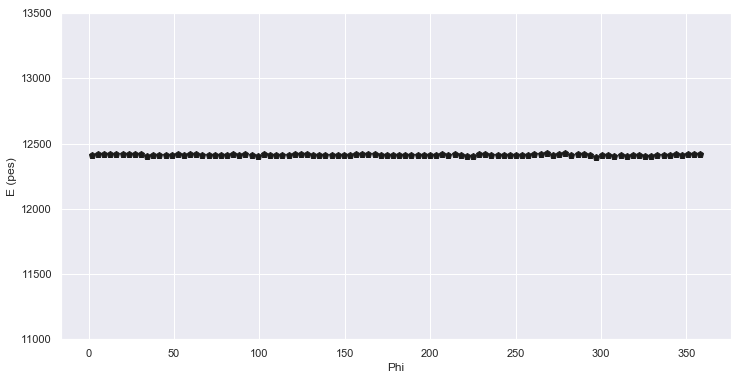

In [78]:
energy_X_profile(phirad_to_deg(kre.Phi), kre.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13500),  
                 figsize=(12,6))

### Dependence with Z

#### Before: shows the effect of lifetime

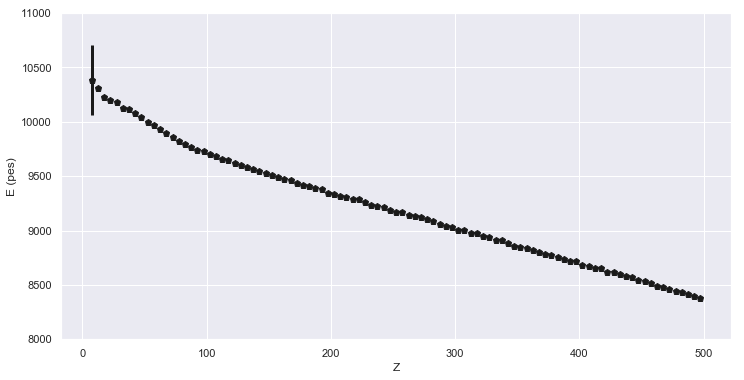

In [79]:
energy_X_profile(dst.Z, dst.S2e, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After: Lifetime corrected

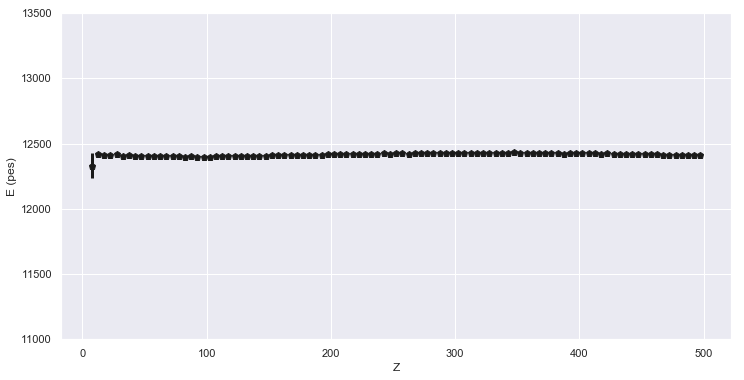

In [80]:
energy_X_profile(kre.Z, kre.E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13500),   
                 figsize=(12,6))

### Time correction

(11000, 13500)

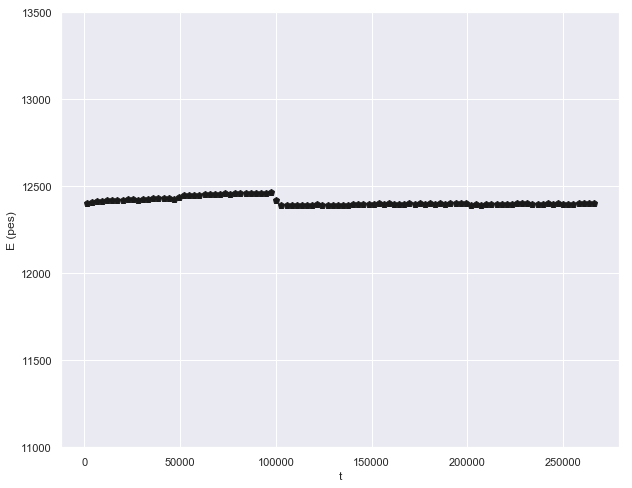

In [83]:
T   =(kre.T - kre.T.min()) 
t, e, eu = fitf.profileX(T, kre.E, 100)
erange =(11000, 13500)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E (pes)')
plt.ylim(erange)

In [84]:
e_mu    = np.nanmean(kre.E)
print(e_mu)
e_std   = np.nanstd (kre.E)
print(e_std)

12414.496137668533
303.9336006273433


In [86]:
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ek  = kre.E * ET_correction(T).value

(11000, 13500)

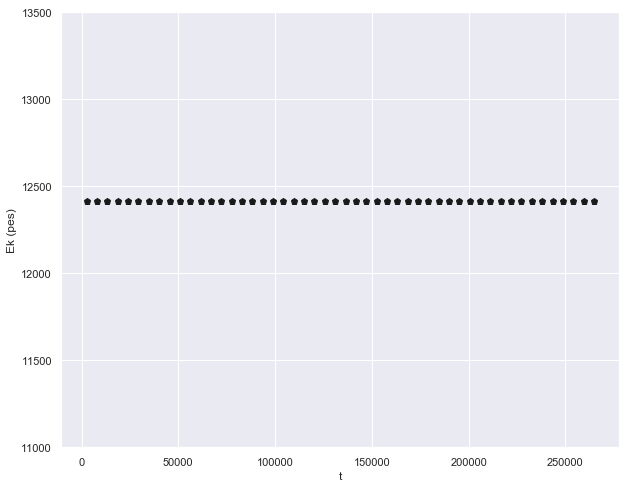

In [87]:
tc, ec, euc = fitf.profileX(T, Ek, 50)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('Ek (pes)')
plt.ylim(erange)

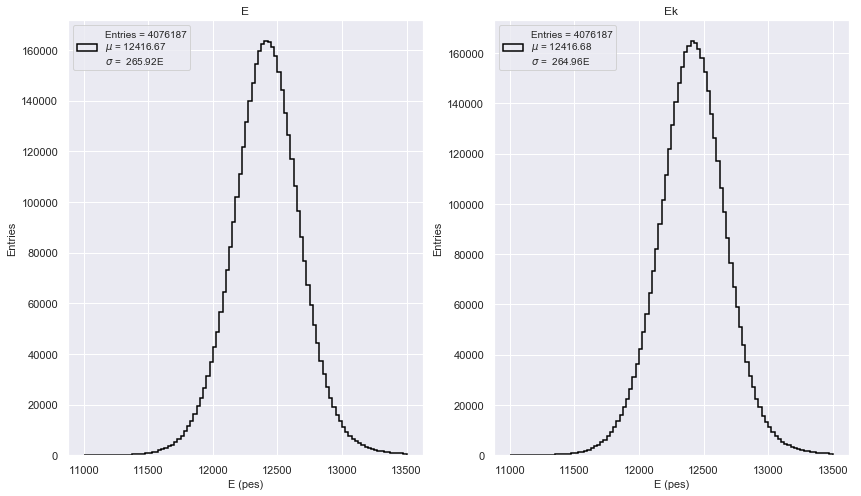

In [88]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

(_)     = h1(kre.E,  bins = 100, range =(11000,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ek,  bins = 100, range =(11000,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Ek'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12415.661010784132 +-0.12869147209090168 
 E sigma   = 255.64227491257157 +-0.09998444480854556 
 chi2    = 20.784309035883464 
 sigma E/E (FWHM)     (%) =4.838722203535752
 sigma E/E (FWHM) Qbb (%) =0.6249304387921593 


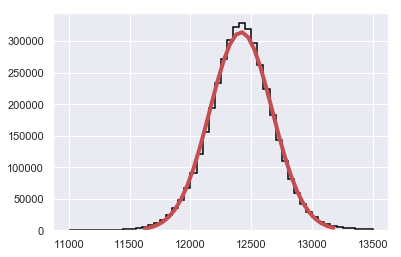

In [90]:
fc = fit_energy(Ek, nbins=50, range=(11000, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

### As a function of R and Z

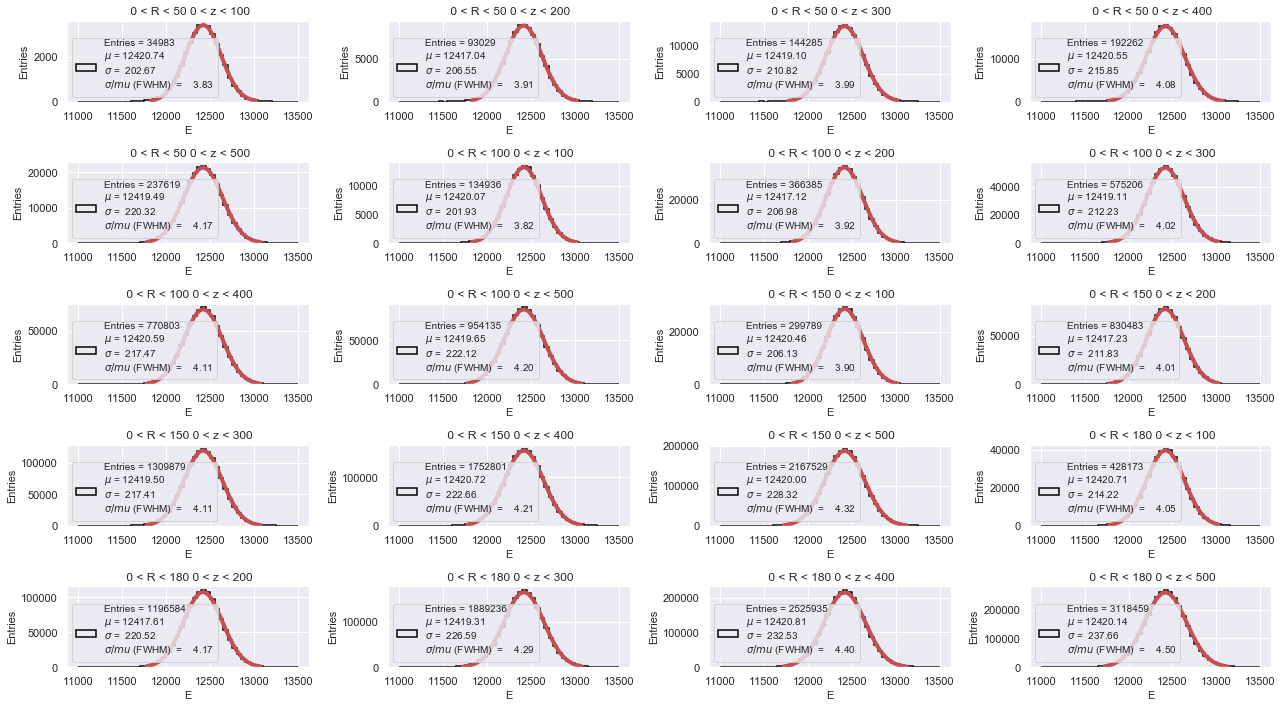

In [95]:
Ri = (50,100,150,180)
Zi = (100,200,300,400,500)

FC, FCE = resolution_r_z(Ri, Zi, kre.R, kre.Z, Ek,
                    enbins = 50,
                    erange = (11e+3, 13500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))                                

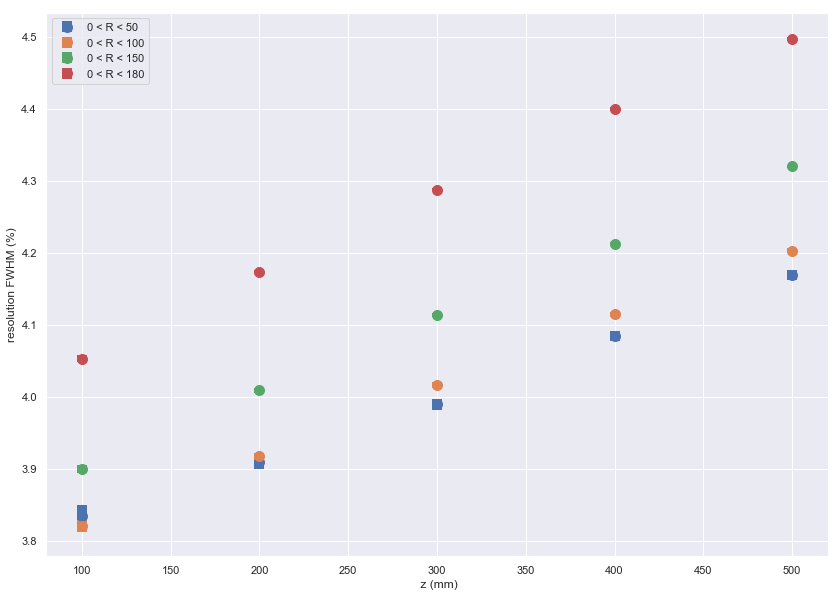

In [97]:
plot_resolution_r_z(Ri, Zi, FC, FCE)